In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
%reload_ext autoreload

In [44]:
import logging
import logging.config
import configparser
import os
import time
from pathlib import Path
import signal
from cachepath import CachePath, TempPath, Path
import requests
import shutil



import lmsquery
from waveshare_epd import epd5in83

In [45]:
import cfg
import epdlib

In [29]:
# this works best as a global variable
logConfig = Path(cfg.LOGCONFIG)
logging.config.fileConfig(logConfig.absolute())
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(name)s %(levelname)s: %(message)s')

logger = logging.getLogger(__name__)

In [30]:
appShortName = 'slimpi'
name = 'com.txoof.'
appLongName = name+appShortName

In [31]:
def configuration(configFile=None):
    
    configDefaults = cfg.CONFIGDEFAULTS
    
    if not configFile:
         configFile = Path(cfg.CONFIGFILE)

    config = configparser.ConfigParser()
    logger.info(f'reading configuration: {configFile}')
    config.read(configFile)
    
    try:
        for section in configDefaults:
            if section not in config.sections():
                logger.debug(f'adding section: {section}')
                config.add_section(section)
            
            for option in configDefaults[section]:
                if not config.has_option(section, option):
                    logger.debug(f'missing option: {option}')
                    logger.debug(f'setting {option} to: {configDefaults[section][option]}')
                    config[section][option] = str(configDefaults[section][option])
            with open(configFile, 'w') as file:
                config.write(file)
    
    except Exception as e:
        logging.exception(f'exception on configuration file: {e}')
        raise
    
    logger.debug(f'config file contains sections: {config.sections()}')
    return config

In [32]:
def query(lms, last=0, delay=7):
    '''query the player only when a specified delay has passed
    Accepts:
        last: float - last time query was called

    Returns:
        tuple(last, lms.now_playing()
    '''
    if last==0:
        last = time.clock_gettime(time.CLOCK_MONOTONIC)-delay

    if time.clock_gettime(time.CLOCK_MONOTONIC) > last+delay:
        return time.clock_gettime(time.CLOCK_MONOTONIC), lms.now_playing()

    else:
        return last, None

In [33]:
def cacheArt(query={}):
    if not query:
        return None
    
    cachePath = CachePath(appLongName, dir=True)
    required = ['artwork_url', 'album_id'] 
    missing = []
    
    for key in required:
        if not key in query:
            missing.append(key)
    if missing:
        logger.warning(f'required value(s) in `query` missing: {missing}')
        return None
    
    albumArtFile = cachePath/(query['album_id']+'.jpg')
    
    # check if file already exists in cache
    if albumArtFile.exists():
        logging.debug(f'album artwork already downloaded at: {albumArtFile}')
        return albumArtFile
    
    r = False
    albumArtURL = query['artwork_url']
    
    # try to fetch the album art
    try:
        r = requests.get(albumArtURL, stream=True)
    except requests.exceptions.RequestException as e:
        logging.error(f'failed to fetch artwork at {albumArtURL}: {e}')
        
    if r:
        try:
            with open(albumArtFile, 'wb') as outFile:
                shutil.copyfileobj(r.raw, outFile)
                logging.debug(f'wrote album art to: {albumArtFile}')
        except (OSError, FileExistsError, ValueError) as e:
            logging.error(f'failed to write {albumArtFile}: {e}')
    else:
        logging.error('skipping download of album artwork due to previous errors')

    return albumArtFile
    

In [34]:
class signalHandler(object):
    '''handle specific signals and allow graceful exiting while loop
    https://stackoverflow.com/a/31464349/5530152
    
    Signals Handled Gracefully:
        SIGINT
        SIGTERM
    Atributes:
        kill_now (bool) default: False
    '''
    kill_now = False
    def __init__(self):
        signal.signal(signal.SIGINT, self.exit_gracefully)
        signal.signal(signal.SIGTERM, self.exit_gracefully)
    
    def exit_gracefully(self, signum, frame):
        self.kill_now = True

In [41]:
def main():
    '''main entry point
    '''   
    logger.setLevel(logging.DEBUG)
    logger.info('Starting program')
    config = configuration()
    # scan for lms server and use the first one (this may be a terrible idea for other people)
#     lmsServer = lmsquery.scanLMS()[0]
    
    # define LMS query object
#     lms = lmsquery.LMSQuery(lmsServer['host'], lmsServer['port'], config.get('server', 'player'))
    lms = lmsquery.LMSQuery(player_id=config.get('server', 'player'))
    
    screen = epdlib.Screen()
    screen.epd = epd5in83.EPD()
    screen.initEPD()
#     screen.clearEPD()
    layout = epdlib.Layout(layout=epdlib.layouts.threeRow)
    layout.update_contents(query(lms, 0)[1])
    screen.initEPD()
    screen.elements=layout.blocks.values()
#     screen.concat()
#     screen.writeEPD()    
    
    
    sigHandler = signalHandler()
    
    # last update
    updated = 0
    # id of currently playing track
    nowPlayingID = None
    # status of player 
    nowPlayingMode = None

    # now playing fields to display
    fields = ['title', 'album', 'artist', 'mode', 'artwork_url']
    
    
    print(f'pid: {os.getpid()}')
    try:
        while not sigHandler.kill_now:
            # add some try: around this
            updated, value = query(lms=lms, last=updated, delay=3)
            
            response = value
            
            # if there's a response, check to see if display needs an update
            if response: 
                # if the album ID changed the player state changed, update the display
                if response['id'] != nowPlayingID or response['mode'] != nowPlayingMode:
                    
                    albumArt = cacheArt(response)
                    
                    if not albumArt:
                        albumArt = cfg.NOIMAGE
                        
                    value['coverart'] = str(albumArt)
                    
                    layout.update_contents(value)
                    screen.initEPD()
                    screen.elements=layout.blocks.values()
                    screen.concat()
                    screen.writeEPD()                      
                    
                    nowPlayingID = response['id']
                    nowPlayingMode = response['mode']
                    for field in fields:
                        print(f'{field}: {response[field]}')
                    print('\n')
            time.sleep(0.5)
    finally:
        print("cleaning up")
        screen.initEPD()
        screen.clearEPD()
        return layout    

In [46]:
if __name__ == '__main__':
    
    foo = main()

epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
Layout:layout:191:DEBUG - calculating values from layout for resolution (600, 448)
Layout:_calculate_layout:221:DEBUG - ***title***
Layout:_check_keys:108:DEBUG - checking key/values
Layout:_check_keys:113:DEBUG - missing key: dimensions; adding and setting to None
Layout:_calculate_layout:228:DEBUG - dimensions: (600, 179)
Layout:_calculate_layout:257:DEBUG - has explict position
Layout:_calculate_layout:259:DEBUG - abs_coordinates: (0, 0)
Layout:_scalefont:134:DEBUG - calculating font size
Layout:_scalefont:135:DEBUG - using font at path: /home/pi/src/slimpi_epd/fonts/Open_Sans/OpenSans-Regular.ttf
Layout:_scalefont:147:DEBUG - target X font dimension 510.0
Layout:_scalefont:148:DEBUG - target Y dimension: 62.65
Layout:_scalefont:165:DEBUG - Y target exceeded
Layout:_scalefont:177:DEBUG - test string: W W W ; dimensions for fontsize 58: (210, 64)
Layout:_calculate_layout:221:DEBUG - ***coverar

Layout:update_contents:311:DEBUG - updating blocks
Layout:update_contents:320:DEBUG - ignoring block id
Layout:update_contents:317:DEBUG - updating block: title
Block:text_formatter:315:DEBUG - formatted list:
 ['Birthday']
Block:_text2image:344:DEBUG - text image dimensions: (231, 76)
Block:_text2image:356:DEBUG - h-center line: Birthday
Block:_text2image:364:DEBUG - h-center image coordinates
Block:_text2image:369:DEBUG - v-center image coordinates
Block:_text2image:373:DEBUG - image coordinates (184, 52)
Layout:update_contents:317:DEBUG - updating block: artist
Block:text_formatter:315:DEBUG - formatted list:
 ['The Beatles']
Block:_text2image:344:DEBUG - text image dimensions: (156, 31)
Block:_text2image:369:DEBUG - v-center image coordinates
Block:_text2image:373:DEBUG - image coordinates (360, 209)
Layout:update_contents:320:DEBUG - ignoring block coverid
Layout:update_contents:320:DEBUG - ignoring block duration
Layout:update_contents:320:DEBUG - ignoring block album_id
Layout:u

In [5]:
    sc = epdlib.Screen()
    sc.epd = epd5in83.EPD()
    sc.initEPD()
    sc.clearEPD()

True

In [6]:
tl = epdlib.Layout(layout=epdlib.layouts.clock)

In [7]:
from PIL import Image

In [8]:
i = Image.new('1', (600, 7), color=0)

In [9]:
upd = {'time': '20:40', 'mode': 'stopped', 'bar': i}
tl.update_contents(upd)

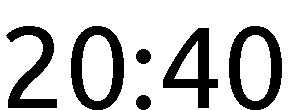

In [10]:
tl.blocks['time'].image

In [11]:
sc.elements = tl.blocks.values()

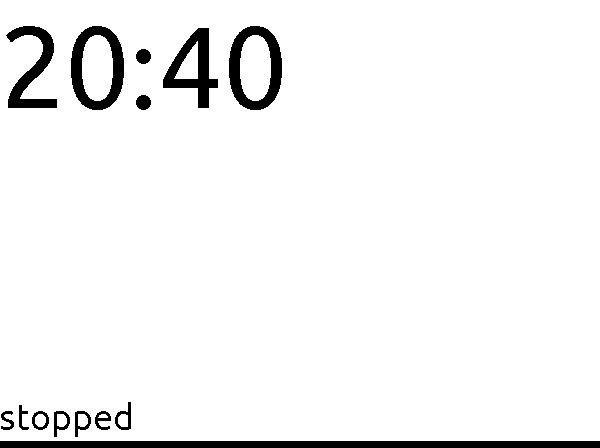

In [12]:
sc.concat()

In [14]:
sc.initEPD()
sc.writeEPD()

True

In [ ]:
import datetime

In [ ]:
l = epdlib.Layout(resolution=(600, 392))

In [ ]:
l._scalefont(font='./fonts/Ubuntu/Ubuntu-Regular.ttf', dimensions=(600,392))

In [ ]:
b = epdlib.Block.TextBlock(font='./fonts/Ubuntu/Ubuntu-Regular.ttf', font_size=87, area=(600, 392))

In [ ]:
help(b)

In [ ]:
t = datetime.datetime.now().time()
timeStr = f'{t.hour}:{t.minute}'